# Dynamic tuning

In [1]:
%cd ..

D:\Projects\Python\Euro-NeurIPS-2022


In [2]:
import glob
import itertools

import pandas as pd
from scipy import stats
import tomli

import tools

In [3]:
def res2data(where: str):
    with open(where, "r") as fh:
        data = fh.readlines()

    seed = int(where.split("-")[-1].removesuffix(".txt"))
    data = data[3:-5]  # remove headers and aggregate rows
    rows = [datum.strip().split() for datum in data]
    return [
        (inst, seed, int(cost), int(iters), tools.name2size(inst))
        for inst, feas, cost, iters, _ in rows
        if feas == "Y"
    ]

def size2group(size: int):
    if size < 300:
        return "small"
    elif 300 <= size <= 500:
        return "medium"
    else:
        return "large"

def read(group: str, exp: int):
    instances = glob.glob(f"data/tune/{group}/res-{exp}-*.txt")
    records = itertools.chain.from_iterable([res2data(inst) for inst in instances])

    df = pd.DataFrame(records, columns=["instance", "seed", "cost", "iters", "size"])
    df["size_group"] = df["size"].apply(size2group)
    df["exp"] = exp

    with open(f"data/tune/{group}/{exp}.toml", "rb") as fh:
        static_config = tomli.load(fh)

    for param, value in static_config["static"]["params"].items():
        df[param] = value
    
    return df

## Penalty parameters

In [4]:
dfs = [read("sim_penalty", exp) for exp in range(1, 101)]
df = pd.concat(dfs)
df.head()

,instance,seed,cost,iters,size,size_group,exp,initialTimeWarpPenalty,nbPenaltyManagement,feasBooster,penaltyIncrease,penaltyDecrease,targetFeasible,repairProbability,repairBooster
0,ORTEC-VRPTW-ASYM-a9d4edc2-d1-n200-k15,1,158845,65,200,small,1,25,1,2.0,1.2,0.25,0.4,0,10
1,ORTEC-VRPTW-ASYM-ef7dad5e-d1-n200-k12,1,130909,100,200,small,1,25,1,2.0,1.2,0.25,0.4,0,10
2,ORTEC-VRPTW-ASYM-9016f313-d1-n200-k20,1,188429,74,200,small,1,25,1,2.0,1.2,0.25,0.4,0,10
3,ORTEC-VRPTW-ASYM-fd32ebe8-d1-n201-k15,1,142934,70,201,small,1,25,1,2.0,1.2,0.25,0.4,0,10
4,ORTEC-VRPTW-ASYM-8512fc31-d1-n201-k20,1,170195,107,201,small,1,25,1,2.0,1.2,0.25,0.4,0,10


In [5]:
fields = [
    "initialTimeWarpPenalty",
    "nbPenaltyManagement",
    "feasBooster",
    "penaltyIncrease",
    "penaltyDecrease",
    "targetFeasible",
    "repairProbability",
    "repairBooster",    
]

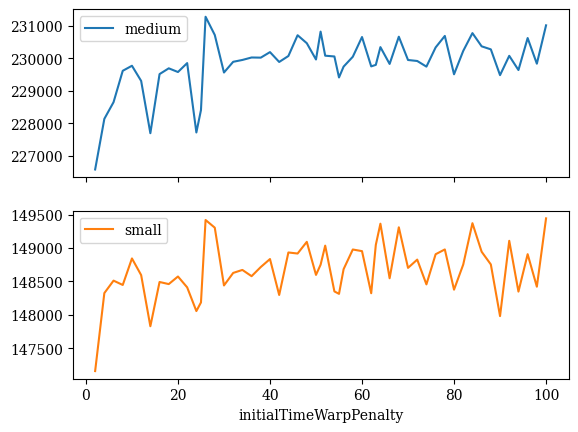

In [6]:
df.cost.groupby([df["initialTimeWarpPenalty"], df["size_group"]]).mean().unstack().plot(subplots=True);

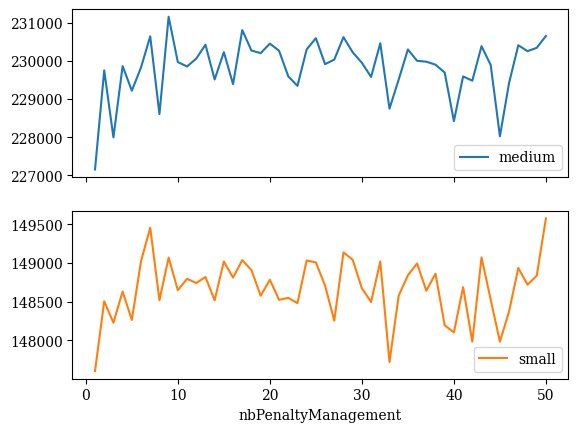

In [7]:
df.cost.groupby([df["nbPenaltyManagement"], df["size_group"]]).mean().unstack().plot(subplots=True);

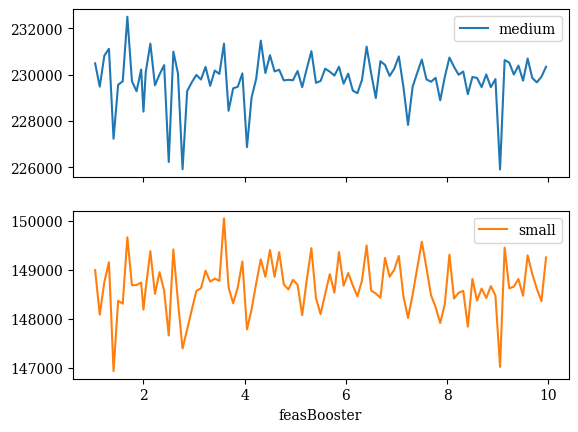

In [8]:
df.cost.groupby([df["feasBooster"], df["size_group"]]).mean().unstack().plot(subplots=True);

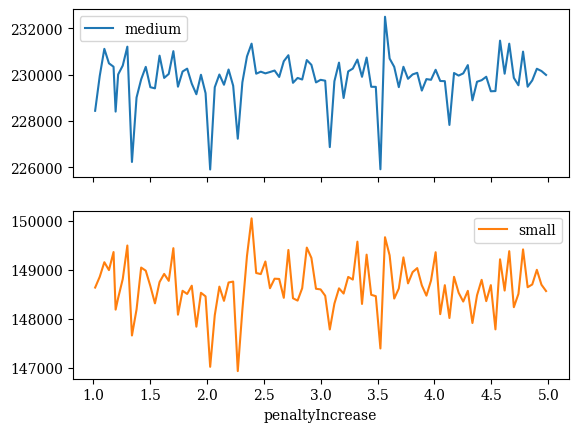

In [9]:
df.cost.groupby([df["penaltyIncrease"], df["size_group"]]).mean().unstack().plot(subplots=True);

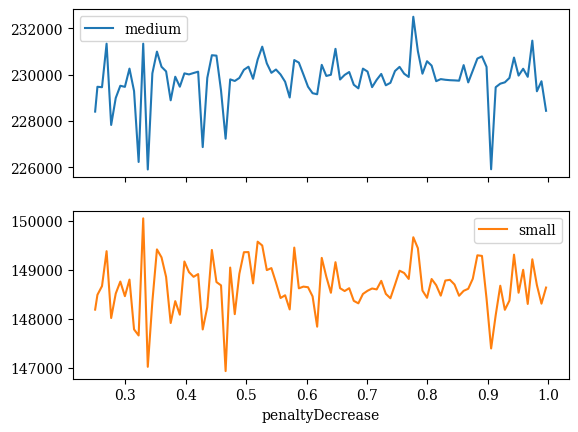

In [10]:
df.cost.groupby([df["penaltyDecrease"], df["size_group"]]).mean().unstack().plot(subplots=True);

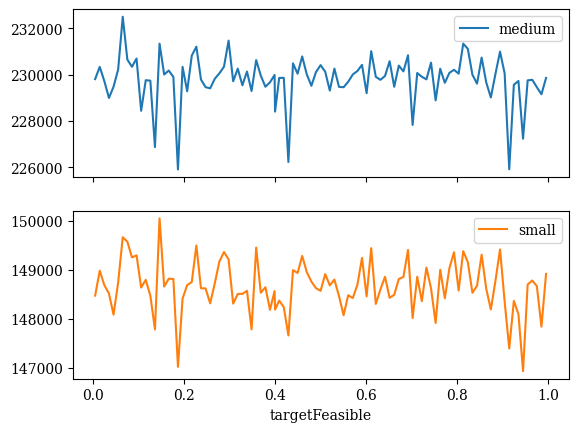

In [11]:
df.cost.groupby([df["targetFeasible"], df["size_group"]]).mean().unstack().plot(subplots=True);

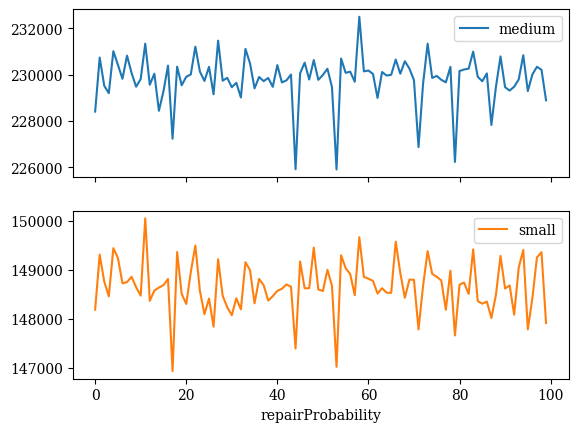

In [12]:
df.cost.groupby([df["repairProbability"], df["size_group"]]).mean().unstack().plot(subplots=True);

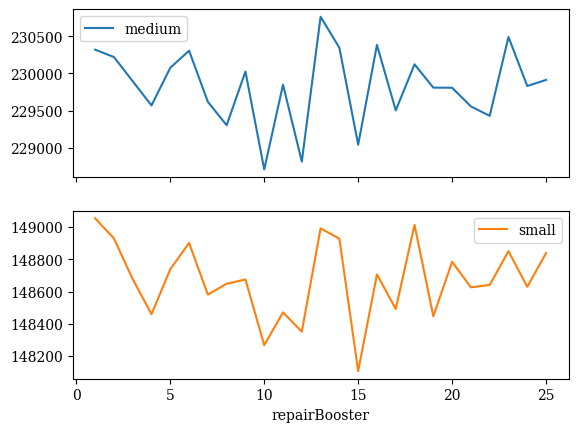

In [13]:
df.cost.groupby([df["repairBooster"], df["size_group"]]).mean().unstack().plot(subplots=True);

Is there any significant improvement?

In [14]:
mean_value = df[df.exp == 1].cost.mean()

for exp in range(1, 101):
    data = df[df.exp == exp]
    test = stats.ttest_1samp(data.cost, mean_value, alternative='less')
    mean = data.cost.mean()

    if mean <= mean_value:
        print(f"{exp:>3}  {test.pvalue:.2f}  {mean:.0f}")

  1  0.50  187955
  9  0.21  186990
 44  0.38  187582
 50  0.13  186610
 53  0.07  186125
 67  0.09  186320
 72  0.20  186740


Could we do better with separate configurations for each group size, rather than one size fits all?